In [ ]:
!pip install --upgrade torch==1.9.1+cu111 torchvision==0.10.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install --upgrade https://download.pytorch.org/whl/nightly/cu111/torch-1.11.0.dev20211012%2Bcu111-cp37-cp37m-linux_x86_64.whl https://download.pytorch.org/whl/nightly/cu111/torchvision-0.12.0.dev20211012%2Bcu111-cp37-cp37m-linux_x86_64.whl
!git clone https://github.com/NVlabs/stylegan3
!git clone https://github.com/openai/CLIP
!pip install -e ./CLIP
!pip install einops ninja

import sys
sys.path.append('./CLIP')
sys.path.append('./stylegan3')

import io
import os, time, glob
import pickle
import shutil
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import requests
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import clip
import unicodedata
import re
from tqdm.notebook import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from IPython.display import display
from einops import rearrange
from google.colab import files

device = torch.device('cuda:0')

Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.9.1+cu111 (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.0+cu113, 1.11.0+cu115, 1.11.0+rocm4.3.1, 1.11.0+rocm4.5.2, 1.12.0, 1.12.0+cpu, 1.12.0+cu102, 1.12.0+cu113, 1.12.0+cu116, 1.12.0+rocm5.0, 1.12.0+rocm5.1.1, 1.12.1, 1.12.1+cpu, 1.12.1+cu102, 1.12.1+cu113, 1.12.1+cu116, 1.12.1+rocm5.0, 1.12.1+rocm5.1.1, 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.0+rocm5.1.1, 1.13.0+rocm5.2, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 1.13.1+rocm5.1.1, 1.13.1+rocm5.2, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.0+rocm5.3, 2.0.0+rocm5.4.2, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 2.0.1+rocm5.3, 2.0.1+rocm5.4.2, 2.1.0, 2.1.0+cpu, 2.1.0+cpu.cxx11.abi, 2.1.0+cu118, 2.1.0+cu121, 2.

In [ ]:
def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')

def fetch_model(url_or_path):
    if "drive.google" in url_or_path:
      if "18MOpwTMJsl_Z17q-wQVnaRLCUFZYSNkj" in url_or_path:
        basename = "wikiart-1024-stylegan3-t-17.2Mimg.pkl"
      elif "14UGDDOusZ9TMb-pOrF0PAjMGVWLSAii1" in url_or_path:
        basename = "lhq-256-stylegan3-t-25Mimg.pkl"
    else:
        basename = os.path.basename(url_or_path)
    if os.path.exists(basename):
        return basename
    else:
        if "drive.google" not in url_or_path:
          !wget -c '{url_or_path}'
        else:
          path_id = url_or_path.split("id=")[-1]
          !gdown --id '{path_id}'
        return basename


def norm1(prompt):
    "Normalize to the unit sphere."
    return prompt / prompt.square().sum(dim=-1,keepdim=True).sqrt()

def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)

def prompts_dist_loss(x, targets, loss):
    if len(targets) == 1: # Keeps consitent results vs previous method for single objective guidance
      return loss(x, targets[0])
    distances = [loss(x, target) for target in targets]
    return torch.stack(distances, dim=-1).sum(dim=-1)

class MakeCutouts(torch.nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(F.adaptive_avg_pool2d(cutout, self.cut_size))
        return torch.cat(cutouts)

make_cutouts = MakeCutouts(224, 32, 0.5)

def embed_image(image):
  n = image.shape[0]
  cutouts = make_cutouts(image)
  embeds = clip_model.embed_cutout(cutouts)
  embeds = rearrange(embeds, '(cc n) c -> cc n c', n=n)
  return embeds

def embed_url(url):
  image = Image.open(fetch(url)).convert('RGB')
  return embed_image(TF.to_tensor(image).to(device).unsqueeze(0)).mean(0).squeeze(0)

class CLIP(object):
  def __init__(self):
    clip_model = "ViT-B/32"
    self.model, _ = clip.load(clip_model)
    self.model = self.model.requires_grad_(False)
    self.normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                          std=[0.26862954, 0.26130258, 0.27577711])

  @torch.no_grad()
  def embed_text(self, prompt):
      "Normalized clip text embedding."
      return norm1(self.model.encode_text(clip.tokenize(prompt).to(device)).float())

  def embed_cutout(self, image):
      "Normalized clip image embedding."
      return norm1(self.model.encode_image(self.normalize(image)))

clip_model = CLIP()

100%|███████████████████████████████████████| 338M/338M [00:03<00:00, 92.1MiB/s]


In [ ]:


base_url = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/"

Model = 'FFHQ'

model_name = {
    "FFHQ": base_url + "stylegan3-t-ffhqu-1024x1024.pkl",
}

network_url = model_name[Model]

with open(fetch_model(network_url), 'rb') as fp:
  G = pickle.load(fp)['G_ema'].to(device)

zs = torch.randn([10000, G.mapping.z_dim], device=device)
w_stds = G.mapping(zs, None).std(0)

--2024-11-26 04:29:11--  https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-t-ffhqu-1024x1024.pkl
Resolving api.ngc.nvidia.com (api.ngc.nvidia.com)... 52.11.102.223, 35.86.10.33
Connecting to api.ngc.nvidia.com (api.ngc.nvidia.com)|52.11.102.223|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://xfiles.ngc.nvidia.com/org/nvidia/team/research/models/stylegan3/versions/1/files/stylegan3-t-ffhqu-1024x1024.pkl?versionId=Md5ZG3NIS.ZZ7aVEVw1hJgiaxpSozleh&Expires=1732681752&Signature=GLoiiyxC9g6Ka0UmQkvAOjez-fyf~eM-HH-V6It3pYYq6VlZsFyK6QPelCWuAxJ9B5alYpuPXBcANiFvqtskVBcUzP1izPWzarbiLrcL-XACLiLar7SEUszmB6EhY-jn1QI1D5QyFI1piymWWDyfHP39jO5VfhM2u92rNPxJ5BO91JWD9ltbiPke3pn8qq5cIeGV0RNuLLdd37CFydN29iA6DsXPxwEwsk9ql3f7lgkQg5TEAuekoQhcgWSQDO~kSgOZzWEZxawe3QpaKfrpmjKcsdijJE0mblVE7yLftP7m3wbOqqXxH6rEIrvdk8QmnW3UIBEP27ktcPiEGwMhQA__&Key-Pair-Id=KCX06E8E9L60W [following]
--2024-11-26 04:29:12--  https://xfiles.ngc.nvidia.com/org/n

/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.


In [ ]:
texts = "A sad Hot Woman"
steps = 300
seed = 14

texts = [frase.strip() for frase in texts.split("|") if frase]

targets = [clip_model.embed_text(text) for text in texts]

In [ ]:
tf = Compose([
  Resize(224),
  lambda x: torch.clamp((x+1)/2,min=0,max=1),
  ])

def run():
  torch.manual_seed(seed)

  with torch.no_grad():
    qs = []
    losses = []
    for _ in range(8):
      q = (G.mapping(torch.randn([4,G.mapping.z_dim], device=device), None, truncation_psi=0.7) - G.mapping.w_avg) / w_stds
      images = G.synthesis(q * w_stds + G.mapping.w_avg)
      embeds = embed_image(images.add(1).div(2))
      loss = prompts_dist_loss(embeds, targets, spherical_dist_loss).mean(0)
      i = torch.argmin(loss)
      qs.append(q[i])
      losses.append(loss[i])
    qs = torch.stack(qs)
    losses = torch.stack(losses)
    # print(losses)
    # print(losses.shape, qs.shape)
    i = torch.argmin(losses)
    q = qs[i].unsqueeze(0).requires_grad_()

  # Sampling loop
  q_ema = q
  opt = torch.optim.AdamW([q], lr=0.03, betas=(0.0,0.999))
  loop = tqdm(range(steps))
  for i in loop:
    opt.zero_grad()
    w = q * w_stds
    image = G.synthesis(w + G.mapping.w_avg, noise_mode='const')
    embed = embed_image(image.add(1).div(2))
    loss = prompts_dist_loss(embed, targets, spherical_dist_loss).mean()
    loss.backward()
    opt.step()
    loop.set_postfix(loss=loss.item(), q_magnitude=q.std().item())

    q_ema = q_ema * 0.9 + q * 0.1
    image = G.synthesis(q_ema * w_stds + G.mapping.w_avg, noise_mode='const')

    if i % 10 == 0:
      display(TF.to_pil_image(tf(image)[0]))
      print(f"Image {i}/{steps} | Current loss: {loss}")


  0%|          | 0/300 [00:00<?, ?it/s]

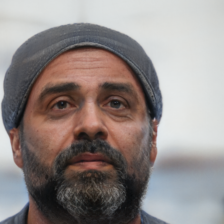

Image 0/300 | Current loss: 2.7677245140075684


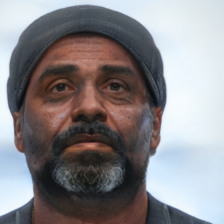

Image 10/300 | Current loss: 2.514831304550171


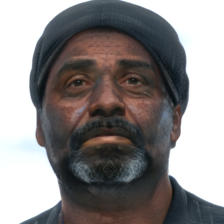

Image 20/300 | Current loss: 2.501035213470459


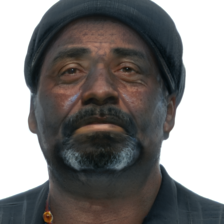

Image 30/300 | Current loss: 2.44878888130188


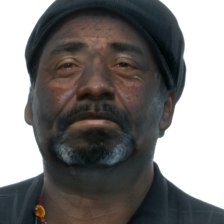

Image 40/300 | Current loss: 2.418027877807617


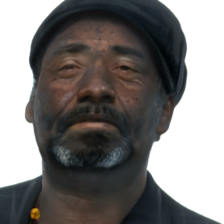

Image 50/300 | Current loss: 2.4392576217651367


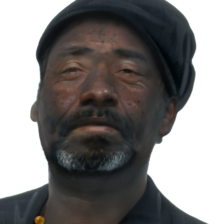

Image 60/300 | Current loss: 2.4085073471069336


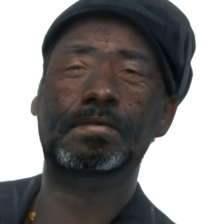

Image 70/300 | Current loss: 2.3948278427124023


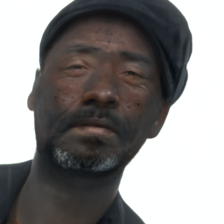

Image 80/300 | Current loss: 2.3912906646728516


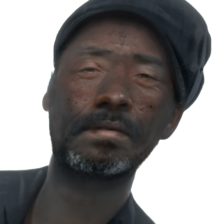

Image 90/300 | Current loss: 2.3957653045654297


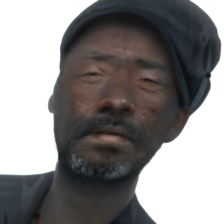

Image 100/300 | Current loss: 2.372781753540039


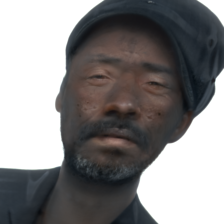

Image 110/300 | Current loss: 2.3608756065368652


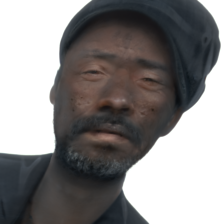

Image 120/300 | Current loss: 2.364027261734009


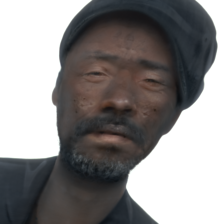

Image 130/300 | Current loss: 2.3686647415161133


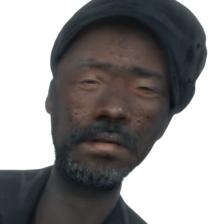

Image 140/300 | Current loss: 2.3561739921569824


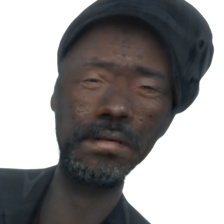

Image 150/300 | Current loss: 2.376707077026367


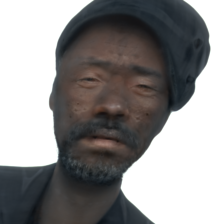

Image 160/300 | Current loss: 2.3798394203186035


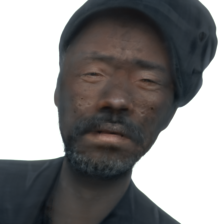

Image 170/300 | Current loss: 2.39524507522583


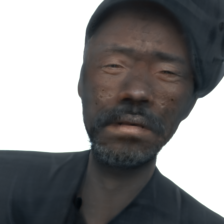

Image 180/300 | Current loss: 2.376756191253662


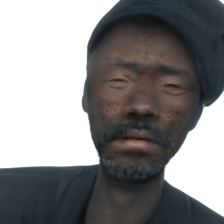

Image 190/300 | Current loss: 2.358043670654297


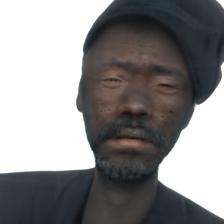

Image 200/300 | Current loss: 2.370753765106201


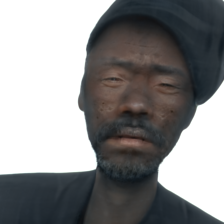

Image 210/300 | Current loss: 2.3629631996154785


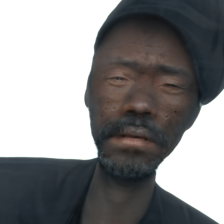

Image 220/300 | Current loss: 2.3799829483032227


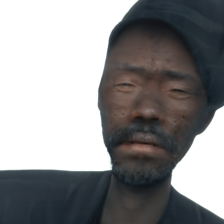

Image 230/300 | Current loss: 2.3923771381378174


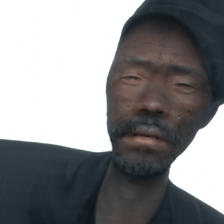

Image 240/300 | Current loss: 2.366971015930176


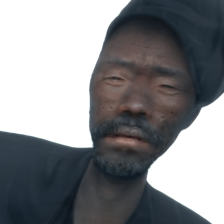

Image 250/300 | Current loss: 2.3515844345092773


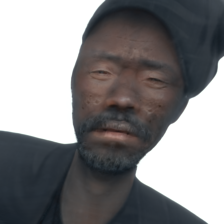

Image 260/300 | Current loss: 2.36305570602417


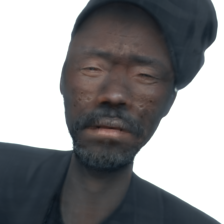

Image 270/300 | Current loss: 2.348682165145874


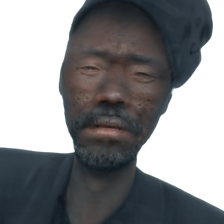

Image 280/300 | Current loss: 2.352800130844116


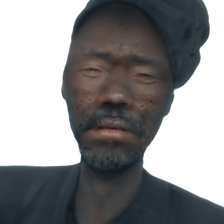

Image 290/300 | Current loss: 2.3355157375335693


In [ ]:
run()